#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pybna\conf.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [7]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('City_of_Davis_Boundary.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

Connecting to database
Copying boundary to database
Loading boundary
Loading data from http://www2.census.gov/geo/tiger/TIGER2010BLKPOPHU/tabblock2010_06_pophu.zip
Filtering blocks to boundary
Filtering out water
Copying blocks to database
Loading data for state CA
No data for state CA for year 2020. Checking previous year.
Copying jobs to database
CPU times: total: 1min 42s
Wall time: 11min 45s


In [8]:
%%time
i.import_osm_network(overwrite=True)

Copying OSM ways to database
Copying OSM intersections to database
Processing OSM data in database
CPU times: total: 30.8 s
Wall time: 2min 15s


In [9]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

Connecting to database
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
  ....forward
  ....backward
CPU times: total: 359 ms
Wall time: 5.57 s


In [4]:
# Read the LTS shape file
lts0=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/neighborhood_ways.shp")
lts0 = lts0.rename(columns={'OSMID':'osmid'})
lts0=lts0.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts0['length']=lts0.length
lts0.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,7898,{249414350},secondary,None,None,1718,559,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (110671.553 112905.829, 110715.995 ...",44.448339
1,14841,{617716534},primary,None,ft,2267,3616,NaN,NaN,lane,...,None,?,?,3,NaN,NaN,1.0,None,"LINESTRING (113878.653 113808.321, 113883.431 ...",13.615555
2,15576,{10747435},tertiary,None,None,1912,3766,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (102682.700 112651.800, 102647.627 ...",35.073038
3,15659,{248096977},path,None,None,1982,4081,NaN,NaN,path,...,None,?,?,1,NaN,1.0,1.0,None,"LINESTRING (109564.470 112068.503, 109601.328 ...",37.430131
4,15999,{990990070},path,None,None,5222,1000,NaN,NaN,path,...,None,?,?,1,1.0,1.0,NaN,None,"LINESTRING (108623.643 111974.308, 108625.263 ...",5.706566


In [5]:
# import crsooing identification buffer
buffer=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis City Network Connectivity/Davis_City_crossing_segments_buffer.shp')
buffer

,Shape_Leng,Shape_Area,geometry
0,325812.892559,1.689877e+07,"MULTIPOLYGON (((113826.497 109819.946, 113833...."


In [6]:
def stress(FT_INT_STR,TF_INT_STR):
    if FT_INT_STR>0:
        return FT_INT_STR
    else:
        return TF_INT_STR
    
def stress2(Stress1,FT_SEG_STR):
    if Stress1>0:
        return Stress1
    else:
        return FT_SEG_STR

In [7]:
crossing_seg=gpd.clip(lts0,buffer)

In [8]:
crossing_seg.groupby(['FT_INT_STR'])['FT_INT_STR'].count()

FT_INT_STR
1.0    5724
2.0      22
3.0     153
4.0      23
Name: FT_INT_STR, dtype: int64

In [9]:
crossing_seg.dtypes

ROAD_ID          int64
osmid           object
FUNCTIONAL      object
PATH_ID         object
ONE_WAY         object
u                int64
v                int64
WIDTH          float64
SPEED_LIMI     float64
FT_BIKE_IN      object
FT_BIKE_01      object
TF_BIKE_IN      object
TF_BIKE_01      object
FT_LANES       float64
TF_LANES       float64
FT_CROSS_L      object
TF_CROSS_L      object
TWLTL_CROS      object
FT_PARK         object
TF_PARK         object
FT_SEG_STR       int64
FT_INT_STR     float64
TF_SEG_STR     float64
TF_INT_STR     float64
XWALK           object
geometry      geometry
length         float64
dtype: object

In [10]:
crossing_seg['Stress1']=crossing_seg.apply(lambda row:stress(row['FT_INT_STR'],row['TF_INT_STR']),axis=1)
crossing_seg['Stress']=crossing_seg.apply(lambda row:stress2(row['Stress1'],row['FT_SEG_STR']),axis=1)
crossing_seg=crossing_seg.drop(['Stress1'],axis=1)
crossing_seg.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
1022,141,{26574659},tertiary,None,None,3221,5525,NaN,35.0,lane,...,?,?,3,NaN,3.0,NaN,None,"LINESTRING (108437.166 110053.834, 108437.272 ...",250.811044,3.0
3626,140,{26574659},tertiary,None,None,5638,5525,NaN,35.0,lane,...,?,?,3,NaN,3.0,1.0,None,"LINESTRING (108437.491 110114.791, 108437.272 ...",43.764448,1.0
6229,9071,{1011882589},path,None,None,3401,6183,NaN,NaN,path,...,?,?,1,NaN,1.0,1.0,None,"LINESTRING (108425.513 110117.699, 108424.765 ...",39.600771,1.0
7362,15091,{25313934},path,None,None,3401,5638,NaN,NaN,path,...,?,?,1,3.0,1.0,1.0,None,"LINESTRING (108425.513 110117.699, 108429.366 ...",12.567383,3.0
3625,139,{791062615},tertiary,None,None,5638,2373,NaN,NaN,lane,...,?,?,3,NaN,3.0,1.0,None,"LINESTRING (108437.491 110114.791, 108437.493 ...",235.579293,1.0
7255,14502,{25313934},path,None,None,3401,826,NaN,NaN,path,...,?,?,1,NaN,1.0,1.0,None,"LINESTRING (108425.513 110117.699, 108423.699 ...",232.458385,1.0
1021,126,{791062615},tertiary,None,None,2373,4082,NaN,NaN,lane,...,?,?,3,NaN,3.0,NaN,None,"LINESTRING (108435.444 110423.691, 108434.923 ...",134.236046,3.0
3624,127,{545225088},tertiary,None,ft,878,4082,NaN,NaN,lane,...,?,?,3,NaN,NaN,1.0,None,"LINESTRING (108427.163 110578.125, 108434.923 ...",93.848864,1.0
201,125,{324606230},tertiary,None,ft,4082,1651,NaN,35.0,lane,...,?,?,3,NaN,NaN,NaN,None,"LINESTRING (108434.923 110484.598, 108436.894 ...",120.024771,3.0
377,26,{545225088},tertiary,None,ft,4892,878,NaN,NaN,lane,...,?,?,3,1.0,NaN,NaN,None,"LINESTRING (108425.440 110598.506, 108427.163 ...",20.453272,1.0


In [11]:
#crossing_seg.isnull().sum()

In [12]:
seg = lts0.overlay(crossing_seg, how='difference')
seg['Stress']=seg['FT_SEG_STR']
seg.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
0,15576,{10747435},tertiary,None,None,1912,3766,NaN,NaN,None,...,?,?,4,NaN,4.0,NaN,None,"LINESTRING (102682.700 112651.800, 102647.627 ...",35.073038,4
1,316,"{25354528,617922203,1060523183}",secondary,None,ft,1535,2554,NaN,35.0,None,...,?,?,4,NaN,NaN,NaN,None,"LINESTRING (107514.924 112627.353, 107478.875 ...",115.355111,4
2,326,{10745041},motorway_link,None,ft,5974,5364,NaN,NaN,None,...,?,?,4,1.0,NaN,NaN,None,"LINESTRING (107468.849 118008.366, 107463.165 ...",561.788633,4
3,328,{540648951},motorway_link,None,ft,4796,2625,NaN,NaN,None,...,?,?,4,NaN,NaN,4.0,None,"LINESTRING (107682.314 117487.278, 107681.690 ...",581.551756,4
4,317,{254087394},secondary,None,ft,2507,1535,NaN,30.0,None,...,?,?,4,NaN,NaN,1.0,None,"MULTILINESTRING ((107799.419 112626.484, 10760...",284.497912,4


In [13]:
lts=pd.concat([crossing_seg,seg],axis=0)
lts.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
1022,141,{26574659},tertiary,None,None,3221,5525,NaN,35.0,lane,...,?,?,3,NaN,3.0,NaN,None,"LINESTRING (108437.166 110053.834, 108437.272 ...",250.811044,3.0
3626,140,{26574659},tertiary,None,None,5638,5525,NaN,35.0,lane,...,?,?,3,NaN,3.0,1.0,None,"LINESTRING (108437.491 110114.791, 108437.272 ...",43.764448,1.0
6229,9071,{1011882589},path,None,None,3401,6183,NaN,NaN,path,...,?,?,1,NaN,1.0,1.0,None,"LINESTRING (108425.513 110117.699, 108424.765 ...",39.600771,1.0
7362,15091,{25313934},path,None,None,3401,5638,NaN,NaN,path,...,?,?,1,3.0,1.0,1.0,None,"LINESTRING (108425.513 110117.699, 108429.366 ...",12.567383,3.0
3625,139,{791062615},tertiary,None,None,5638,2373,NaN,NaN,lane,...,?,?,3,NaN,3.0,1.0,None,"LINESTRING (108437.491 110114.791, 108437.493 ...",235.579293,1.0


In [14]:
lts=gpd.GeoDataFrame.explode(lts).reset_index()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17368\3477233637.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lts=gpd.GeoDataFrame.explode(lts).reset_index()


In [15]:
lts0.shape,crossing_seg.shape, seg.shape,lts.shape

((8351, 27), (7810, 28), (2331, 28), (11321, 30))

# Lets calculate the slope for each link

In [17]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

EPSG:4269


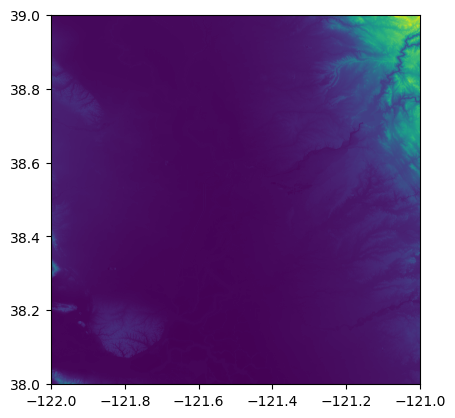

<AxesSubplot:>

In [18]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/slope/USGS_13_n39w122_20220206.tif')
print(barea_slope.crs)
rioplot.show(barea_slope)

In [19]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -7.3393726, 'mean': 42.889994523835824, 'max': 681.56647}


In [20]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry
0,1022,0,141,{26574659},tertiary,None,None,3221,5525,NaN,...,?,?,3,NaN,3.0,NaN,None,250.811044,3.0,"LINESTRING (-121.75696 38.52321, -121.75696 38..."
1,3626,0,140,{26574659},tertiary,None,None,5638,5525,NaN,...,?,?,3,NaN,3.0,1.0,None,43.764448,1.0,"LINESTRING (-121.75695 38.52376, -121.75696 38..."
2,6229,0,9071,{1011882589},path,None,None,3401,6183,NaN,...,?,?,1,NaN,1.0,1.0,None,39.600771,1.0,"LINESTRING (-121.75709 38.52379, -121.75710 38..."
3,7362,0,15091,{25313934},path,None,None,3401,5638,NaN,...,?,?,1,3.0,1.0,1.0,None,12.567383,3.0,"LINESTRING (-121.75709 38.52379, -121.75704 38..."
4,3625,0,139,{791062615},tertiary,None,None,5638,2373,NaN,...,?,?,3,NaN,3.0,1.0,None,235.579293,1.0,"LINESTRING (-121.75695 38.52376, -121.75695 38..."
5,7255,0,14502,{25313934},path,None,None,3401,826,NaN,...,?,?,1,NaN,1.0,1.0,None,232.458385,1.0,"LINESTRING (-121.75709 38.52379, -121.75711 38..."
6,1021,0,126,{791062615},tertiary,None,None,2373,4082,NaN,...,?,?,3,NaN,3.0,NaN,None,134.236046,3.0,"LINESTRING (-121.75695 38.52654, -121.75695 38..."
7,3624,0,127,{545225088},tertiary,None,ft,878,4082,NaN,...,?,?,3,NaN,NaN,1.0,None,93.848864,1.0,"LINESTRING (-121.75703 38.52793, -121.75695 38..."
8,201,0,125,{324606230},tertiary,None,ft,4082,1651,NaN,...,?,?,3,NaN,NaN,NaN,None,120.024771,3.0,"LINESTRING (-121.75695 38.52709, -121.75692 38..."
9,377,0,26,{545225088},tertiary,None,ft,4892,878,NaN,...,?,?,3,1.0,NaN,NaN,None,20.453272,1.0,"LINESTRING (-121.75705 38.52812, -121.75703 38..."


In [21]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot:>

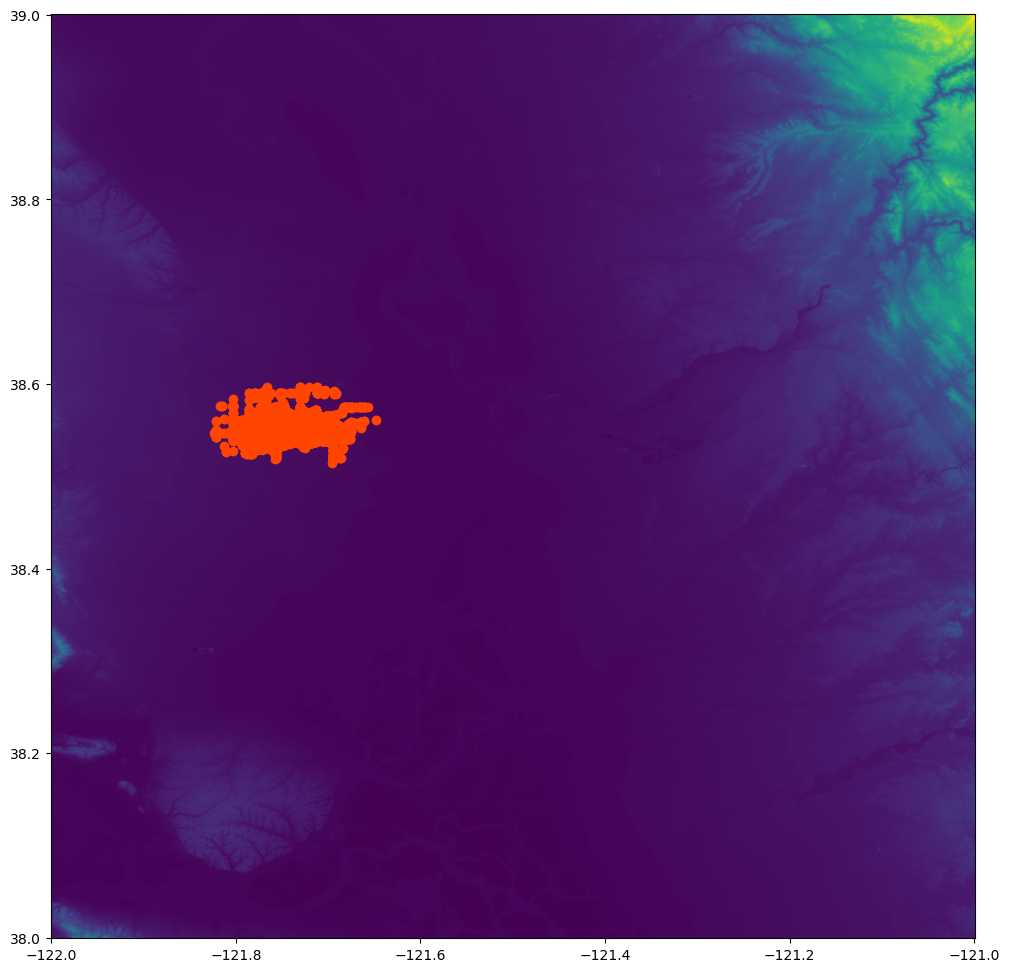

In [22]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [23]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,141,POINT (-121.75695979989207 38.52320983113598),-121.756960,38.523210
1,140,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759
2,9071,POINT (-121.7570879 38.5237859),-121.757088,38.523786
3,15091,POINT (-121.7570879 38.5237859),-121.757088,38.523786
4,139,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759


In [24]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [25]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 234 ms
Wall time: 230 ms


,ROAD_ID,geometry,end_lon,end_lat
0,141,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365
1,140,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365
2,9071,POINT (-121.7570999 38.5234293),-121.757100,38.523429
3,15091,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759
4,139,POINT (-121.75694955945245 38.52432340934131),-121.756950,38.524323


In [26]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 234 ms
Wall time: 230 ms


In [27]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 328 ms
Wall time: 322 ms


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope
0,141,POINT (-121.75695979989207 38.52320983113598),-121.756960,38.523210,15.451972,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,1022,...,0,3.0,0,0,250.811044,3.0,"LINESTRING (-121.75696 38.52321, -121.75696 38...",POINT (-121.75695979989207 38.52320983113598),POINT (-121.75695709999998 38.523364699999995),0.026628
8,140,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,3626,...,0,3.0,1.0,0,43.764448,1.0,"LINESTRING (-121.75695 38.52376, -121.75696 38...",POINT (-121.7569508 38.523758900000004),POINT (-121.75695709999998 38.523364699999995),0.123932
9,9071,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7570999 38.5234293),-121.757100,38.523429,15.583919,6229,...,0,1.0,1.0,0,39.600771,1.0,"LINESTRING (-121.75709 38.52379, -121.75710 38...",POINT (-121.7570879 38.5237859),POINT (-121.7570999 38.5234293),0.130990
10,15091,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,7362,...,3.0,1.0,1.0,0,12.567383,3.0,"LINESTRING (-121.75709 38.52379, -121.75704 38...",POINT (-121.7570879 38.5237859),POINT (-121.7569508 38.523758900000004),1.562508
11,139,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75694955945245 38.52432340934131),-121.756950,38.524323,15.606750,3625,...,0,3.0,1.0,0,235.579293,1.0,"LINESTRING (-121.75695 38.52376, -121.75695 38...",POINT (-121.7569508 38.523758900000004),POINT (-121.75694955945245 38.52432340934131),0.071027


<AxesSubplot:>

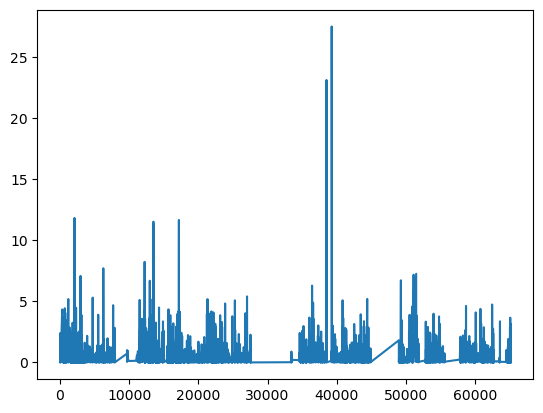

In [28]:
barea_all1.slope.plot()

In [29]:
# write a slope impedance function
def slope_correction(length,Stress,slope):
    if slope <=2:
        return length*(1+Stress)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+Stress)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+Stress)
    else:
        return length*(1+3.20+Stress)

In [30]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['Stress']=pd.to_numeric(barea_all1['Stress']).astype(int)
barea_all1['Stress'].dtypes

dtype('int32')

In [31]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['Stress'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,141,POINT (-121.75695979989207 38.52320983113598),-121.756960,38.523210,15.451972,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,1022,...,3.0,0,0,250.811044,3,"LINESTRING (-121.75696 38.52321, -121.75696 38...",POINT (-121.75695979989207 38.52320983113598),POINT (-121.75695709999998 38.523364699999995),0.026628,1003.244176
8,140,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,3626,...,3.0,1.0,0,43.764448,1,"LINESTRING (-121.75695 38.52376, -121.75696 38...",POINT (-121.7569508 38.523758900000004),POINT (-121.75695709999998 38.523364699999995),0.123932,87.528896
9,9071,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7570999 38.5234293),-121.757100,38.523429,15.583919,6229,...,1.0,1.0,0,39.600771,1,"LINESTRING (-121.75709 38.52379, -121.75710 38...",POINT (-121.7570879 38.5237859),POINT (-121.7570999 38.5234293),0.130990,79.201543
10,15091,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,7362,...,1.0,1.0,0,12.567383,3,"LINESTRING (-121.75709 38.52379, -121.75704 38...",POINT (-121.7570879 38.5237859),POINT (-121.7569508 38.523758900000004),1.562508,50.269533
11,139,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75694955945245 38.52432340934131),-121.756950,38.524323,15.606750,3625,...,3.0,1.0,0,235.579293,1,"LINESTRING (-121.75695 38.52376, -121.75695 38...",POINT (-121.7569508 38.523758900000004),POINT (-121.75694955945245 38.52432340934131),0.071027,471.158586
19,14502,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.75709900372622 38.524334395229495),-121.757099,38.524334,15.790822,7255,...,1.0,1.0,0,232.458385,1,"LINESTRING (-121.75709 38.52379, -121.75711 38...",POINT (-121.7570879 38.5237859),POINT (-121.75709900372622 38.524334395229495),0.066692,464.916771
27,126,POINT (-121.75694759326039 38.526541535509),-121.756948,38.526542,15.959148,POINT (-121.75694829999999 38.5270902),-121.756948,38.527090,16.128407,1021,...,3.0,0,0,134.236046,3,"LINESTRING (-121.75695 38.52654, -121.75695 38...",POINT (-121.75694759326039 38.526541535509),POINT (-121.75694829999999 38.5270902),0.126090,536.944185
35,127,POINT (-121.75702920000002 38.5279332),-121.757029,38.527933,16.264524,POINT (-121.75694829999999 38.5270902),-121.756948,38.527090,16.128407,3624,...,0,1.0,0,93.848864,1,"LINESTRING (-121.75703 38.52793, -121.75695 38...",POINT (-121.75702920000002 38.5279332),POINT (-121.75694829999999 38.5270902),0.145040,187.697728


### Lets Calculate the Connectivity

## Helper Function

In [32]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [33]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [34]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [35]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

## Connectivity

In [36]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((3516926.098 77059.002, 3516963.104 7..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((3519482.809 73938.168, 3519490.446 7..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((3521117.478 74718.075, 3521099.105 7..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((3521674.809 77662.170, 3521681.008 7..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((3525078.936 76191.813, 3525244.092 7..."


In [37]:
# read the Davis boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/City_of_Davis_Boundary.shp")
study_bd

,OBJECTID,CITYCODE,CITY_NAME,SQ_MILES,ACRES,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,3,None,Davis,9.926877,6353.200981,{8E8354F3-0188-49F2-AE1F-F1AE13B3B12E},0.356762,0.00269,"POLYGON ((-121.74783 38.57547, -121.74568 38.5..."


<AxesSubplot:>

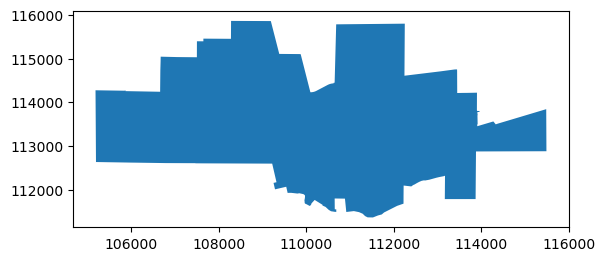

In [38]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [39]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
12648,G0600950253300,06,095,253300,06095253300,2533,Census Tract 2533,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110019.341 111667.333, 110026...."
13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.435 111805.693, 113865.830 11..."
13251,G0601130010501,06,113,010501,06113010501,105.01,Census Tract 105.01,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105193.571 112647.576, 105194...."
13261,G0601130010607,06,113,010607,06113010607,106.07,Census Tract 106.07,G5020,S,3538352.0,0.0,+38.5407306,-121.7024346,8346.169693,3.538353e+06,"POLYGON ((113861.957 113385.440, 113862.237 11..."
13262,G0601130010608,06,113,010608,06113010608,106.08,Census Tract 106.08,G5020,S,2121573.0,0.0,+38.5412556,-121.7230816,7160.791989,2.121574e+06,"POLYGON ((112150.914 111662.855, 112076.374 11..."


In [40]:
#census_track2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/Davis_City_cnesus_Tract.shp")

In [41]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,OBJECTID,CITYCODE,CITY_NAME,SQ_MILES,ACRES,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,area
0,3,None,Davis,9.926877,6353.200981,{8E8354F3-0188-49F2-AE1F-F1AE13B3B12E},0.356762,0.00269,"POLYGON ((109189.169 115860.705, 109381.779 11...",10.050553


In [42]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    10.050553
dtype: float64

In [43]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,141,POINT (-121.75695979989207 38.52320983113598),-121.756960,38.523210,15.451972,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,1022,...,3.0,0,0,250.811044,3,"LINESTRING (108437.166 110053.834, 108437.272 ...",POINT (-121.75695979989207 38.52320983113598),POINT (-121.75695709999998 38.523364699999995),0.026628,1003.244176
8,140,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75695709999998 38.523364699999995),-121.756957,38.523365,15.385187,3626,...,3.0,1.0,0,43.764448,1,"LINESTRING (108437.491 110114.791, 108437.272 ...",POINT (-121.7569508 38.523758900000004),POINT (-121.75695709999998 38.523364699999995),0.123932,87.528896
9,9071,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7570999 38.5234293),-121.757100,38.523429,15.583919,6229,...,1.0,1.0,0,39.600771,1,"LINESTRING (108425.513 110117.699, 108424.765 ...",POINT (-121.7570879 38.5237859),POINT (-121.7570999 38.5234293),0.130990,79.201543
10,15091,POINT (-121.7570879 38.5237859),-121.757088,38.523786,15.635792,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,7362,...,1.0,1.0,0,12.567383,3,"LINESTRING (108425.513 110117.699, 108429.366 ...",POINT (-121.7570879 38.5237859),POINT (-121.7569508 38.523758900000004),1.562508,50.269533
11,139,POINT (-121.7569508 38.523758900000004),-121.756951,38.523759,15.439425,POINT (-121.75694955945245 38.52432340934131),-121.756950,38.524323,15.606750,3625,...,3.0,1.0,0,235.579293,1,"LINESTRING (108437.491 110114.791, 108437.493 ...",POINT (-121.7569508 38.523758900000004),POINT (-121.75694955945245 38.52432340934131),0.071027,471.158586


In [44]:
# Now lets crop the Davis area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
3199,2866,POINT (-121.6945359 38.5402844),-121.694536,38.540284,9.406321,POINT (-121.69385170000001 38.540272599999994),-121.693852,38.540273,8.926793,4910,...,0,3.0,0,60.653686,1,"LINESTRING (113865.394 111992.135, 113871.273 ...",POINT (-121.6945359 38.5402844),POINT (-121.69385170000001 38.540272599999994),0.790599,121.307372
3200,2865,POINT (-121.69385170000001 38.540272599999994),-121.693852,38.540273,8.926793,POINT (-121.6945359 38.5402844),-121.694536,38.540284,9.406321,8021,...,0,1.0,0,60.649395,3,"LINESTRING (113871.307 111994.357, 113865.394 ...",POINT (-121.69385170000001 38.540272599999994),POINT (-121.6945359 38.5402844),0.790655,242.597579
3282,233,POINT (-121.6945470770526 38.53805290988727),-121.694547,38.538053,9.031137,POINT (-121.69456930000001 38.5386013),-121.694569,38.538601,9.327052,1853,...,4.0,0,0,95.950672,1,"LINESTRING (113866.174 111791.987, 113866.148 ...",POINT (-121.6945470770526 38.53805290988727),POINT (-121.69456930000001 38.5386013),0.308404,191.901345
3290,7626,POINT (-121.69803209109537 38.53862128826316),-121.698032,38.538621,9.577580,POINT (-121.6973341 38.5386184),-121.697334,38.538618,9.598286,3538,...,3.0,0,0,65.324700,1,"LINESTRING (113562.084 111805.015, 113622.943 ...",POINT (-121.69803209109537 38.53862128826316),POINT (-121.6973341 38.5386184),0.031696,130.649400
3298,232,POINT (-121.6973341 38.5386184),-121.697334,38.538618,9.598286,POINT (-121.69663587306805 38.538614072948135),-121.696636,38.538614,9.445477,7816,...,3.0,1.0,0,241.074339,3,"LINESTRING (113622.943 111805.192, 113683.824 ...",POINT (-121.6973341 38.5386184),POINT (-121.69663587306805 38.538614072948135),0.063386,964.297358


In [45]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17368\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


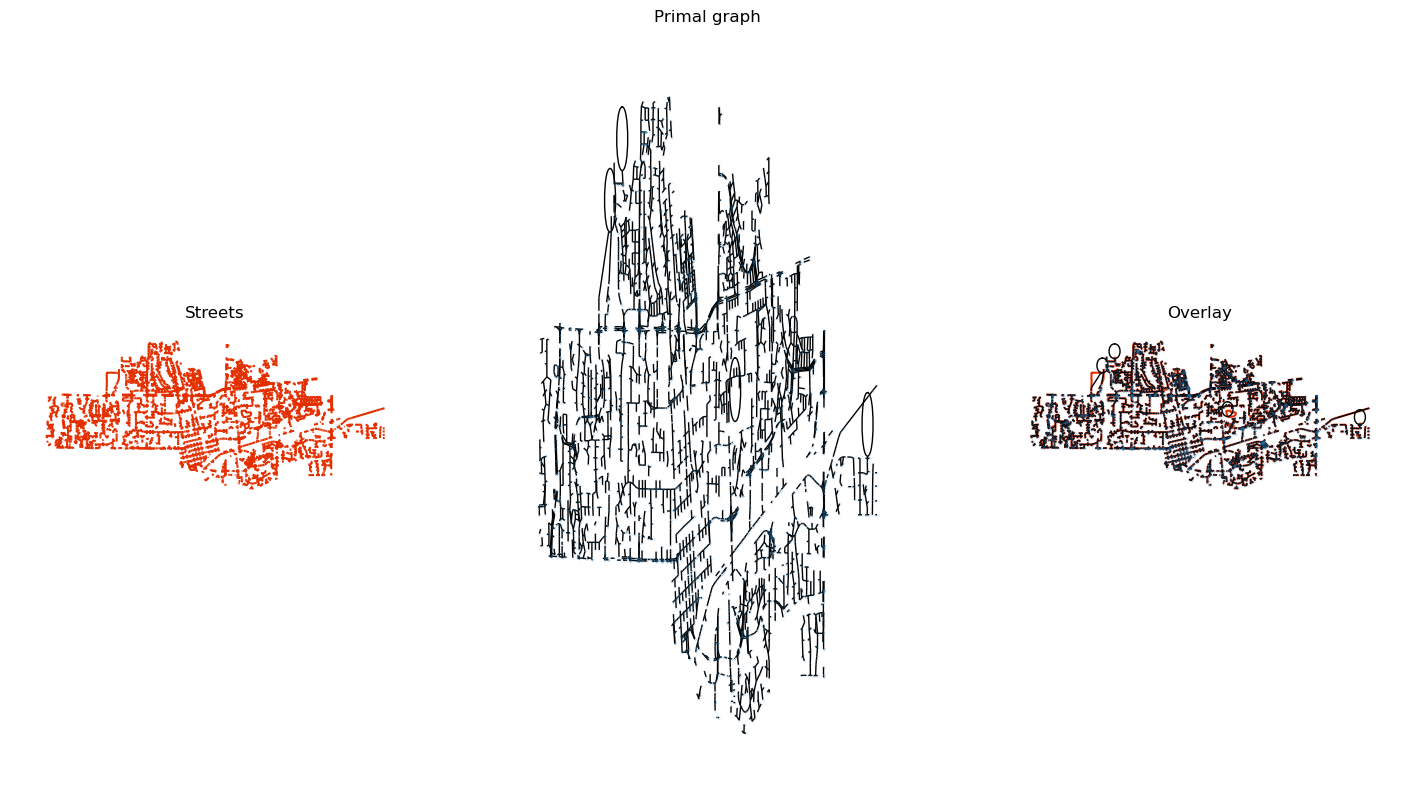

In [194]:
  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
  sf_lts.plot(color='#e32e00', ax=ax[0])
  for i, facet in enumerate(ax):
      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
      facet.axis("off")
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot:>

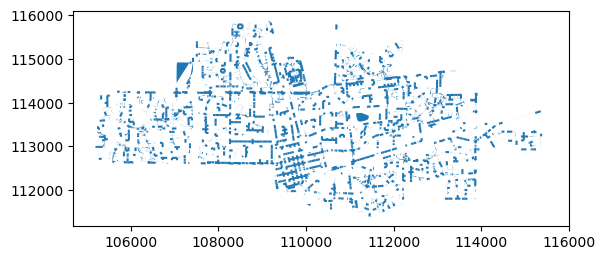

In [195]:
sf_lts['geometry'].convex_hull.plot()

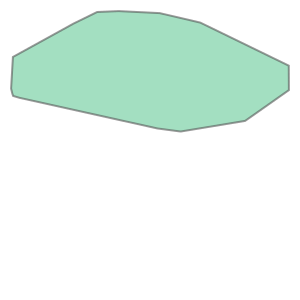

In [46]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

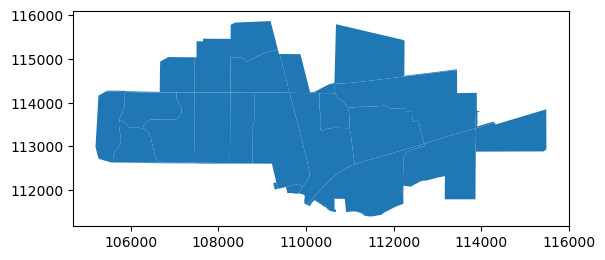

In [47]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [48]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

32706341.5758273

In [49]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [50]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [51]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

2055

# Bicycle Vs Motor Network Connectivity

<AxesSubplot:>

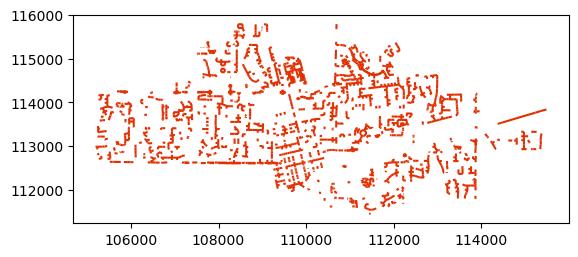

In [52]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

In [55]:
sf_motor_network.groupby(['Stress'])['Stress'].count()

Stress
1    2347
2      16
3      51
4      93
Name: Stress, dtype: int64

<AxesSubplot:>

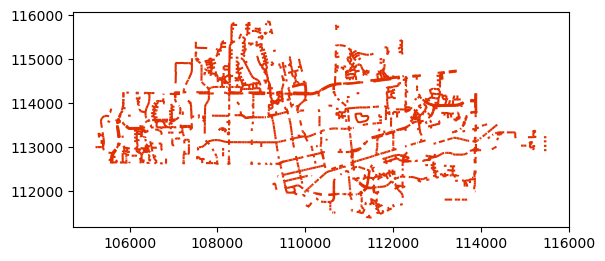

In [53]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [56]:
sf_bike_network.groupby(['Stress'])['Stress'].count()

Stress
1    2779
2       5
3     559
4      26
Name: Stress, dtype: int64

In [204]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(20, 17)

In [205]:
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,3.164828e+07,1.683743e+08,5.32017


In [206]:
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1.425425e+02,1.223682e+03,8.584678,12648,G0600950253300,06,095,253300,06095253300,2533,Census Tract 2533,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110019.341 111667.333, 110026...."
1,3.396922e+05,2.927822e+05,0.861904,13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.435 111805.693, 113865.830 11..."
2,2.949732e+05,4.451029e+05,1.508961,13251,G0601130010501,06,113,010501,06113010501,105.01,Census Tract 105.01,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105193.571 112647.576, 105194...."
3,1.258597e+06,1.042878e+06,0.828603,13261,G0601130010607,06,113,010607,06113010607,106.07,Census Tract 106.07,G5020,S,3538352.0,0.0,+38.5407306,-121.7024346,8346.169693,3.538353e+06,"POLYGON ((113861.957 113385.440, 113862.237 11..."
4,4.950101e+05,4.367087e+06,8.822217,13262,G0601130010608,06,113,010608,06113010608,106.08,Census Tract 106.08,G5020,S,2121573.0,0.0,+38.5412556,-121.7230816,7160.791989,2.121574e+06,"POLYGON ((112150.914 111662.855, 112076.374 11..."


In [207]:
cs_census_track['Connectivity score'].median()

2.5662442654046504

In [208]:
cs_census_track['Connectivity score'].mean()

6.484519070926329

In [209]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_B_vs_Motor_seg_corss.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\1315454831.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_B_vs_Motor_seg_corss.shp")


In [210]:
gdf ['cs_ranking']=gdf .apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,cs_ranking
0,1.425425e+02,1.223682e+03,8.584678,12648,G0600950253300,06,095,253300,06095253300,2533,...,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110019.341 111667.333, 110026....",excellently connected
1,3.396922e+05,2.927822e+05,0.861904,13249,G0601130010401,06,113,010401,06113010401,104.01,...,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.435 111805.693, 113865.830 11...",well connected
2,2.949732e+05,4.451029e+05,1.508961,13251,G0601130010501,06,113,010501,06113010501,105.01,...,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105193.571 112647.576, 105194....",excellently connected
3,1.258597e+06,1.042878e+06,0.828603,13261,G0601130010607,06,113,010607,06113010607,106.07,...,G5020,S,3538352.0,0.0,+38.5407306,-121.7024346,8346.169693,3.538353e+06,"POLYGON ((113861.957 113385.440, 113862.237 11...",well connected
4,4.950101e+05,4.367087e+06,8.822217,13262,G0601130010608,06,113,010608,06113010608,106.08,...,G5020,S,2121573.0,0.0,+38.5412556,-121.7230816,7160.791989,2.121574e+06,"POLYGON ((112150.914 111662.855, 112076.374 11...",excellently connected


In [211]:
# Now count the census tract for Bay area by cs ranking
gdf.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    15
poorly connected          1
well connected            4
Name: GISJOIN, dtype: int64

# Consider Low Stress Vs Motor Network connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path in motor network

In [57]:
# Split the network as low VS high stress network to get the connectivity by stress level
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['Stress']<3]

In [58]:
sf_bike_network_op2.groupby(['Stress'])['Stress'].count()

Stress
1    5126
2      21
Name: Stress, dtype: int64

In [220]:
# low Vs High stress connectivity score
## Calculate the connectivity score for bike vs motor network condition
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,3.164828e+07,1.412602e+09,44.634385


In [214]:
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,9.985249e+02,1.425425e+02,0.142753
1,5.323489e+05,3.396922e+05,0.638101
2,5.345443e+05,2.949732e+05,0.551822
3,3.030801e+06,1.258597e+06,0.415269
4,6.373868e+06,4.950101e+05,0.077662


In [215]:
SF_CS_hl['Connectivity score'].median()

0.31523826625620355

In [216]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Census_track_level_CS_hl_seg_corss.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_10476\258798906.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Census_track_level_CS_hl_seg_corss.shp")


In [217]:
gdf_hl['cs_ranking']=gdf_hl.apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf_hl.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,cs_ranking
0,9.985249e+02,1.425425e+02,0.142753,12648,G0600950253300,06,095,253300,06095253300,2533,...,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110019.341 111667.333, 110026....",poorly connected
1,5.323489e+05,3.396922e+05,0.638101,13249,G0601130010401,06,113,010401,06113010401,104.01,...,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.435 111805.693, 113865.830 11...",well connected
2,5.345443e+05,2.949732e+05,0.551822,13251,G0601130010501,06,113,010501,06113010501,105.01,...,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105193.571 112647.576, 105194....",fairly connected
3,3.030801e+06,1.258597e+06,0.415269,13261,G0601130010607,06,113,010607,06113010607,106.07,...,G5020,S,3538352.0,0.0,+38.5407306,-121.7024346,8346.169693,3.538353e+06,"POLYGON ((113861.957 113385.440, 113862.237 11...",fairly connected
4,6.373868e+06,4.950101e+05,0.077662,13262,G0601130010608,06,113,010608,06113010608,106.08,...,G5020,S,2121573.0,0.0,+38.5412556,-121.7230816,7160.791989,2.121574e+06,"POLYGON ((112150.914 111662.855, 112076.374 11...",poorly connected


In [218]:
# Now count the census tract for Bay area by cs ranking
gdf_hl.groupby(['cs_ranking'])['cs_ranking'].count()

cs_ranking
fairly connected          6
poorly connected         10
very well connected       1
well connected            3
Name: cs_ranking, dtype: int64

# End of coding